estimar costos con precisión, comparar proveedores y planear el CAPEX/OPEX del proyecto.

# Caso de costos por materias primas (X, Y, Z)

**Objetivo:** leer `X.csv`, `Y.csv`, `Z.csv`, construir el costo de 2 equipos con mezclas de materias primas, calcular **P50 a 36 meses** (pronóstico univariado) y **bandas P10–P90** (Monte Carlo).  
Este notebook NO requiere PySpark. Usa `pandas` + `pmdarima` (si está disponible).


In [1]:
# ===============================
# 0) CONFIGURACIÓN Y RUTAS
# ===============================
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

print("pandas:", pd.__version__)

# Detecta raíz del proyecto y carpeta Datos/
CWD = Path.cwd().resolve()
PROJECT_ROOT = CWD.parent if CWD.name.lower() == "caso" else CWD
DATA_DIR = PROJECT_ROOT / "Datos"
RESULTS_DIR = PROJECT_ROOT / "Resultados"
RESULTS_DIR.mkdir(exist_ok=True, parents=True)

print("CWD:", CWD)
print("Project root:", PROJECT_ROOT)
print("Datos dir:", DATA_DIR, "exists:", DATA_DIR.exists())
print("Resultados dir:", RESULTS_DIR)

# -------------------------------
# CONFIG editable por el usuario
# -------------------------------
# Pesos de materias primas en el costo material
WEIGHTS = {
    "equipo1": {"X": 0.20, "Y": 0.80, "Z": 0.0},
    "equipo2": {"X": 1/3, "Y": 1/3, "Z": 1/3},
}

# Cargos no-materiales (α) en mismas unidades de la serie (se suman al costo)
ALPHA = {"equipo1": 0.0, "equipo2": 0.0}

# Horizonte de pronóstico en meses
HORIZON = 36


pandas: 2.3.3
CWD: C:\Users\nicot\Desktop\Prueba tecnica 1\Caso
Project root: C:\Users\nicot\Desktop\Prueba tecnica 1
Datos dir: C:\Users\nicot\Desktop\Prueba tecnica 1\Datos exists: True
Resultados dir: C:\Users\nicot\Desktop\Prueba tecnica 1\Resultados


## Lectura de datos y normalización temporal

- Lee `X.csv`, `Y.csv`, `Z.csv` con heurística de separador/decimal.
- Detecta columnas de **fecha** y **valor**, convierte a serie mensual (`MS`) y hace `ffill`.


In [2]:
# ===============================
# 1) UTILIDADES DE LECTURA/TS
# ===============================
def _read_csv_any(path: Path):
    """Lee CSV con heurísticas de separador/decimal comunes."""
    last_err = None
    for sep in [",", ";", "\t", "|"]:
        for dec in [".", ","]:
            try:
                df = pd.read_csv(path, sep=sep, decimal=dec, engine="python")
                if df.shape[1] >= 2:
                    return df
            except Exception as e:
                last_err = e
                continue
    if last_err:
        raise last_err
    raise FileNotFoundError(f"No se pudo leer {path} con separadores/decimales típicos.")

def _guess_date_and_value(df: pd.DataFrame, name: str):
    """Intenta detectar columna de fecha y columna de valor numérico; devuelve serie mensual."""
    cols = [str(c).strip().lower() for c in df.columns]
    df.columns = cols

    # columna de fecha (prioriza nombres típicos)
    date_candidates = [c for c in cols if any(k in c for k in ["date", "fecha", "month", "period", "periodo"])]
    date_col = date_candidates[0] if date_candidates else cols[0]
    try:
        dates = pd.to_datetime(df[date_col], errors="coerce")
    except Exception:
        date_col = cols[0]
        dates = pd.to_datetime(df[date_col], errors="coerce")

    # columna de valor: primera numérica disponible
    value_col = None
    for c in cols:
        if c == date_col:
            continue
        s = pd.to_numeric(df[c], errors="coerce")
        if s.notna().sum() > 0:
            value_col = c
            break
    if value_col is None and len(cols) > 1:
        value_col = cols[1]

    s = pd.Series(pd.to_numeric(df[value_col], errors="coerce").values, index=dates, name=name)
    s = s.dropna().sort_index()
    s = s.resample("MS").last().ffill()  # mensual
    return s

def load_series(data_dir: Path):
    paths = {"X": data_dir / "X.csv", "Y": data_dir / "Y.csv", "Z": data_dir / "Z.csv"}
    series = {}
    for k, p in paths.items():
        if not p.exists():
            raise FileNotFoundError(f"No se encontró {p}. Verifica rutas.")
        df = _read_csv_any(p)
        series[k] = _guess_date_and_value(df, k)
    return series

series = load_series(DATA_DIR)
for k, s in series.items():
    print(k, s.index.min().date(), "→", s.index.max().date(), "| n:", len(s))
    display(s.to_frame().tail(3))


X 1988-06-01 → 2024-04-01 | n: 431


,X
date,
2024-02-01,83.62
2024-03-01,87.48
2024-04-01,89.18


Y 2006-01-01 → 2023-12-01 | n: 216


,Y
date,
2023-10-01,560.0
2023-11-01,546.0
2023-12-01,540.0


Z 2010-01-01 → 2023-08-01 | n: 164


,Z
date,
2023-06-01,2096.25
2023-07-01,2195.25
2023-08-01,2165.25


## Costo histórico por equipo

Construye el costo material histórico combinando X, Y, Z con los **pesos** definidos, y suma el **α** no-material.


In [3]:
# ===============================
# 2) COSTO HISTÓRICO POR EQUIPO
# ===============================
eq1_hist = (series["X"] * WEIGHTS["equipo1"]["X"]
            + series["Y"] * WEIGHTS["equipo1"]["Y"]
            + series["Z"] * WEIGHTS["equipo1"]["Z"]) + ALPHA["equipo1"]

eq2_hist = (series["X"] * WEIGHTS["equipo2"]["X"]
            + series["Y"] * WEIGHTS["equipo2"]["Y"]
            + series["Z"] * WEIGHTS["equipo2"]["Z"]) + ALPHA["equipo2"]

eq1_hist.name = "equipo1_hist"
eq2_hist.name = "equipo2_hist"

hist_df = pd.concat([series["X"], series["Y"], series["Z"], eq1_hist, eq2_hist], axis=1)
display(hist_df.tail(5))


,X,Y,Z,equipo1_hist,equipo2_hist
date,,,,,
2023-12-01,77.04,540.0,NaN,NaN,NaN
2024-01-01,81.71,NaN,NaN,NaN,NaN
2024-02-01,83.62,NaN,NaN,NaN,NaN
2024-03-01,87.48,NaN,NaN,NaN,NaN
2024-04-01,89.18,NaN,NaN,NaN,NaN


## Pronóstico P50 (36 meses)

- Usa `pmdarima.auto_arima` si está disponible (detecta ARIMA automáticamente).
- Si no lo está, aplica un **naive con drift** (pendiente media histórica).
- Combina los pronósticos de X/Y/Z con los **pesos** para obtener el P50 por equipo.


In [4]:
# ===============================
# 3) PRONÓSTICO UNIVARIADO (P50)
# ===============================
try:
    import pmdarima as pm
    HAVE_PM = True
except Exception:
    HAVE_PM = False
    print("pmdarima no disponible. Usaré un pronóstico naive (drift).")

def forecast_series(s: pd.Series, horizon: int) -> pd.Series:
    s = s.asfreq("MS").ffill()
    if HAVE_PM:
        model = pm.auto_arima(s, seasonal=False, error_action="ignore", suppress_warnings=True)
        fc = model.predict(n_periods=horizon)
    else:
        dif = s.diff().dropna()
        drift = dif.mean()
        fc = np.array([s.iloc[-1] + (i+1)*drift for i in range(horizon)])
    idx = pd.date_range(s.index[-1] + pd.offsets.MonthBegin(1), periods=horizon, freq="MS")
    return pd.Series(fc, index=idx, name=s.name + "_fc")

# Pronóstico de X, Y, Z
fx = forecast_series(series["X"], HORIZON).rename("X_fc")
fy = forecast_series(series["Y"], HORIZON).rename("Y_fc")
fz = forecast_series(series["Z"], HORIZON).rename("Z_fc")
fc_df = pd.concat([fx, fy, fz], axis=1)

# P50 por equipo
eq1_p50 = (fc_df["X_fc"] * WEIGHTS["equipo1"]["X"]
           + fc_df["Y_fc"] * WEIGHTS["equipo1"]["Y"]
           + fc_df["Z_fc"] * WEIGHTS["equipo1"]["Z"]) + ALPHA["equipo1"]
eq2_p50 = (fc_df["X_fc"] * WEIGHTS["equipo2"]["X"]
           + fc_df["Y_fc"] * WEIGHTS["equipo2"]["Y"]
           + fc_df["Z_fc"] * WEIGHTS["equipo2"]["Z"]) + ALPHA["equipo2"]

eq1_p50.name = "equipo1_p50"
eq2_p50.name = "equipo2_p50"
p50_df = pd.concat([eq1_p50, eq2_p50], axis=1)
display(p50_df.head(5))

# Exporta P50 y series pronosticadas
p50_out = RESULTS_DIR / "costos_p50_36m.csv"
fc_out  = RESULTS_DIR / "series_pronosticadas_XYZ_36m.csv"
p50_df.to_csv(p50_out, index=True)
fc_df.to_csv(fc_out, index=True)
print("Guardado:", p50_out)
print("Guardado:", fc_out)


pmdarima no disponible. Usaré un pronóstico naive (drift).


,equipo1_p50,equipo2_p50
2023-09-01,NaN,NaN
2023-10-01,NaN,NaN
2023-11-01,NaN,NaN
2023-12-01,NaN,NaN
2024-01-01,NaN,NaN


Guardado: C:\Users\nicot\Desktop\Prueba tecnica 1\Resultados\costos_p50_36m.csv
Guardado: C:\Users\nicot\Desktop\Prueba tecnica 1\Resultados\series_pronosticadas_XYZ_36m.csv


## Monte Carlo (bandas P10–P90)

- Calcula **retornos mensuales** históricos de X/Y/Z y su **covarianza**.
- Simula trayectorias futuras con correlaciones (Cholesky).
- Convierte a costo de equipo y obtiene percentiles P10/P50/P90.


In [5]:
# ===============================
# 4) MONTE CARLO (P10–P90)
# ===============================
np.random.seed(42)

# Retornos mensuales
xyz = pd.concat([series["X"], series["Y"], series["Z"]], axis=1).dropna()
xyz.columns = ["X", "Y", "Z"]
rets = xyz.pct_change().dropna()

mu = rets.mean().values
cov = rets.cov().values

# Cholesky (con fallback si no es semidefinida positiva)
try:
    L = np.linalg.cholesky(cov)
except np.linalg.LinAlgError:
    eps = 1e-6
    L = np.linalg.cholesky(cov + np.eye(3)*eps)

n_sims = 5000
h = HORIZON

x0, y0, z0 = xyz.iloc[-1].values
paths_eq1 = np.zeros((h, n_sims))
paths_eq2 = np.zeros((h, n_sims))

for sim in range(n_sims):
    shocks = np.random.randn(h, 3) @ L.T + mu  # agrega drift mensual
    X_path = np.empty(h); Y_path = np.empty(h); Z_path = np.empty(h)
    X_path[0] = x0 * (1 + shocks[0,0])
    Y_path[0] = y0 * (1 + shocks[0,1])
    Z_path[0] = z0 * (1 + shocks[0,2])
    for t in range(1, h):
        X_path[t] = X_path[t-1] * (1 + shocks[t,0])
        Y_path[t] = Y_path[t-1] * (1 + shocks[t,1])
        Z_path[t] = Z_path[t-1] * (1 + shocks[t,2])

    # Evita valores negativos por ruido extremo
    X_path = np.maximum(X_path, 1e-9)
    Y_path = np.maximum(Y_path, 1e-9)
    Z_path = np.maximum(Z_path, 1e-9)

    eq1 = X_path * WEIGHTS["equipo1"]["X"] + Y_path * WEIGHTS["equipo1"]["Y"] + Z_path * WEIGHTS["equipo1"]["Z"] + ALPHA["equipo1"]
    eq2 = X_path * WEIGHTS["equipo2"]["X"] + Y_path * WEIGHTS["equipo2"]["Y"] + Z_path * WEIGHTS["equipo2"]["Z"] + ALPHA["equipo2"]

    paths_eq1[:, sim] = eq1
    paths_eq2[:, sim] = eq2

# Fechas futuras
idx_future = pd.date_range(xyz.index[-1] + pd.offsets.MonthBegin(1), periods=h, freq="MS")

def percentiles(paths):
    return pd.DataFrame({
        "P10": np.percentile(paths, 10, axis=1),
        "P50": np.percentile(paths, 50, axis=1),
        "P90": np.percentile(paths, 90, axis=1),
    }, index=idx_future)

eq1_mc = percentiles(paths_eq1)
eq2_mc = percentiles(paths_eq2)

# Exporta
mc1_out = RESULTS_DIR / "equipo1_mc_p10_p50_p90_36m.csv"
mc2_out = RESULTS_DIR / "equipo2_mc_p10_p50_p90_36m.csv"
eq1_mc.to_csv(mc1_out, index=True)
eq2_mc.to_csv(mc2_out, index=True)
print("Guardado:", mc1_out)
print("Guardado:", mc2_out)

display(eq1_mc.head(3))
display(eq2_mc.head(3))


Guardado: C:\Users\nicot\Desktop\Prueba tecnica 1\Resultados\equipo1_mc_p10_p50_p90_36m.csv
Guardado: C:\Users\nicot\Desktop\Prueba tecnica 1\Resultados\equipo2_mc_p10_p50_p90_36m.csv


,P10,P50,P90
2023-09-01,391.607426,453.715823,516.599645
2023-10-01,367.367167,454.500061,550.716841
2023-11-01,353.177907,451.976296,575.761177


,P10,P50,P90
2023-09-01,875.160742,934.960792,994.988146
2023-10-01,854.283864,936.545497,1023.048561
2023-11-01,839.125892,938.468890,1044.185738


## Visualización rápida

Gráficas simples (histórico, P50, bandas Monte Carlo) para cada equipo.


Text(0, 0.5, 'Costo')

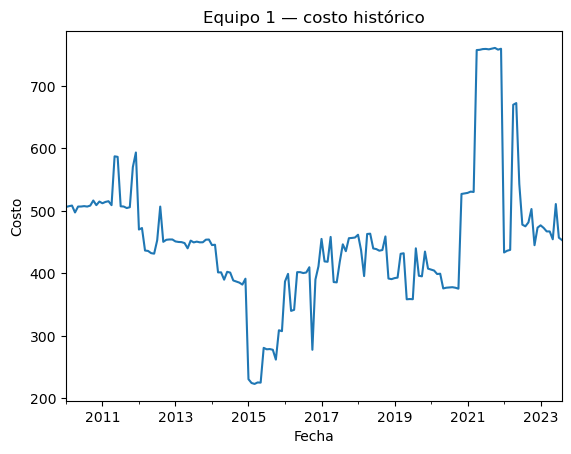

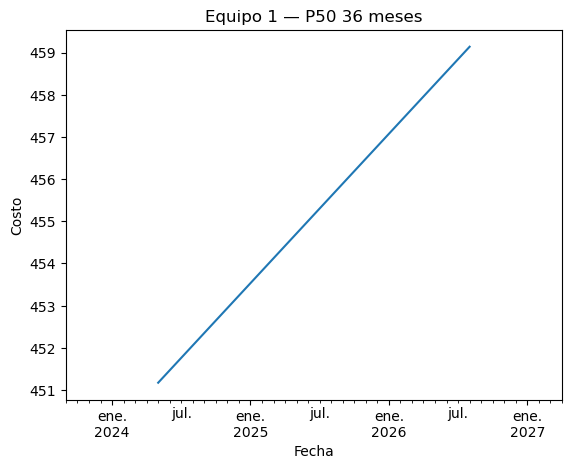

<Figure size 640x480 with 0 Axes>

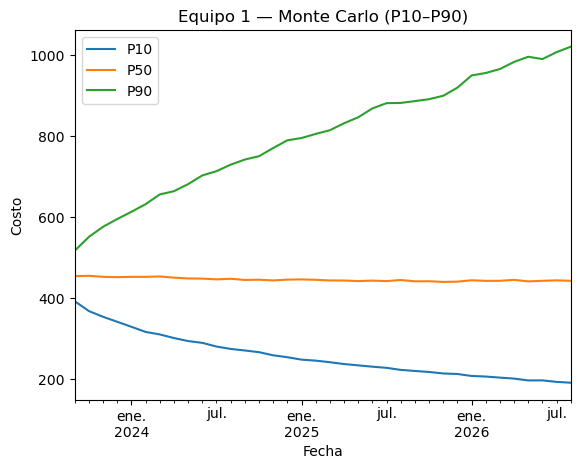

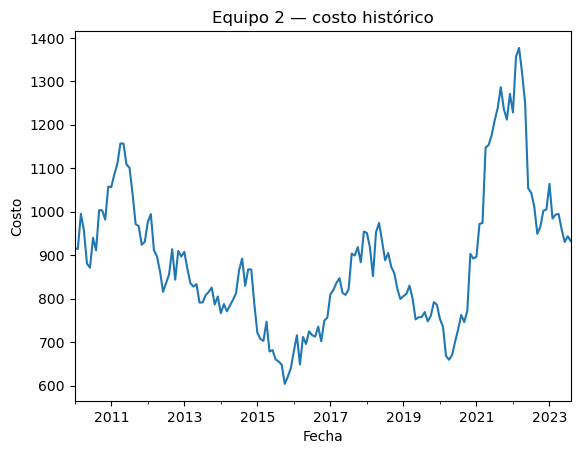

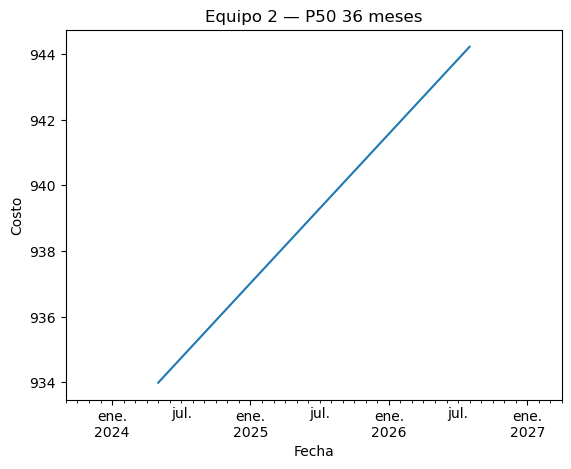

<Figure size 640x480 with 0 Axes>

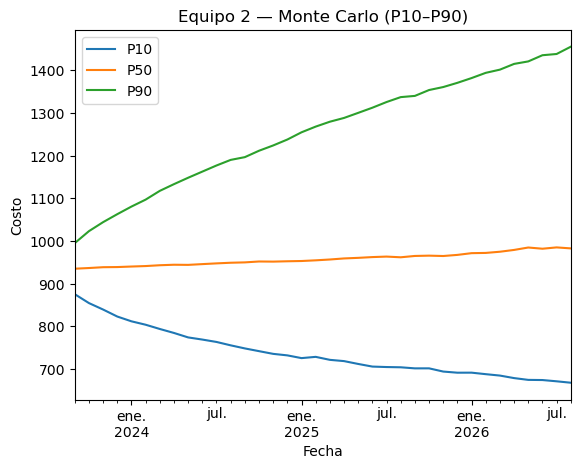

In [6]:
# ===============================
# 5) GRÁFICOS
# ===============================
plt.figure()
hist_df["equipo1_hist"].dropna().plot()
plt.title("Equipo 1 — costo histórico")
plt.xlabel("Fecha"); plt.ylabel("Costo")

plt.figure()
p50_df["equipo1_p50"].plot()
plt.title("Equipo 1 — P50 36 meses")
plt.xlabel("Fecha"); plt.ylabel("Costo")

plt.figure()
eq1_mc[["P10","P50","P90"]].plot()
plt.title("Equipo 1 — Monte Carlo (P10–P90)")
plt.xlabel("Fecha"); plt.ylabel("Costo")

plt.figure()
hist_df["equipo2_hist"].dropna().plot()
plt.title("Equipo 2 — costo histórico")
plt.xlabel("Fecha"); plt.ylabel("Costo")

plt.figure()
p50_df["equipo2_p50"].plot()
plt.title("Equipo 2 — P50 36 meses")
plt.xlabel("Fecha"); plt.ylabel("Costo")

plt.figure()
eq2_mc[["P10","P50","P90"]].plot()
plt.title("Equipo 2 — Monte Carlo (P10–P90)")
plt.xlabel("Fecha"); plt.ylabel("Costo")
